In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('punkt') 
nltk.download('stopwords')

# Carregamento dos dados
for dirname, _, filenames in os.walk('/kaggle/input/nlp-getting-started'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

submission_df = pd.DataFrame(sample_submission)
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

2025-05-10 12:29:21.674987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746880161.861576      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746880161.913993      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_da

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


**LIMPEZA DO TEXTO**

In [2]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = set(stop_words + ['u', 'im', 'c', 'i m'])

def clean_text(mensage):
    mensage = str(mensage).lower()
    mensage = re.sub('https?://\S+|www\.\S+', '', mensage)
    mensage = re.sub(r'@\w+', '', mensage)
    mensage = re.sub('<.*?>+', '', mensage)
    mensage = re.sub('[%s]' % re.escape(string.punctuation), '', mensage)
    mensage = re.sub('\n', '', mensage)
    mensage = re.sub('\w*\d\w*', '', mensage)

    tokens = word_tokenize(mensage)
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(clean_tokens) 

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# Remoção de stopwords

def remove_stopwords(mensage):
    mensage = ' '.join(word for word in mensage.split(' ') if word not in stop_words)
    return mensage

train_df['text'] = train_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)

**DIVISÃO DOS DADOS**

In [3]:
# Divisão dos dados
x = train_df['text']
y = train_df['target']

# Removendo o documento vazio (índice 217)
empty_index = 217
if empty_index in x.index:
    x = x.drop(index=empty_index)
    y = y.drop(index=empty_index)
    y = y.reset_index(drop=True)
    x = x.reset_index(drop=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.23, random_state=19)

# Resetar os índices do x_train e x_test
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

**MODELO SENTENCE TRANSFORMER**

In [4]:
model_name = 'all-mpnet-base-v2'
embedding_model = SentenceTransformer(model_name)

# Gerar os embeddings
x_train_embeddings = embedding_model.encode(x_train, convert_to_tensor=True)
x_test_embeddings = embedding_model.encode(x_test, convert_to_tensor=True)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/184 [00:00<?, ?it/s]

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

**DATASET + DATALOADER**

In [5]:
class DisasterDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = DisasterDataset(x_train_embeddings, y_train_tensor)
test_dataset = DisasterDataset(x_test_embeddings, y_test_tensor)

# Criar DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

**DEFININDO O MODELO**

In [6]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 1)
       
        self.fc2 = nn.Linear(128, 64) 
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


**CONFIGURAÇÕES DE TREINAAMENTO**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(f"Usando dispositivo: {device}")


input_dim = x_train_embeddings.shape[1]
model = SimpleClassifier(input_dim).to(device)
criterion = nn.BCELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Treinar o modelo
epochs = 40
print(f"Iniciando treinamento por {epochs} épocas...")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0
    
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    # Mostrar progresso a cada 5 épocas
    if (epoch + 1) % 5 == 0 or epoch == 0:
        avg_loss = epoch_loss / batch_count
        print(f'Época {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
        
        # Verificar distribuição das previsões em uma amostra
        if epoch == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                sample_data = next(iter(train_loader))
                sample_embeddings, sample_labels = sample_data
                sample_embeddings = sample_embeddings.to(device)
                sample_outputs = model(sample_embeddings)
                sample_preds = (sample_outputs > 0.5).float().cpu().numpy()

Usando dispositivo: cuda
Iniciando treinamento por 40 épocas...
Época 1/40, Loss: 0.6690
Época 5/40, Loss: 0.4450
Época 10/40, Loss: 0.4074
Época 15/40, Loss: 0.3670
Época 20/40, Loss: 0.3390
Época 25/40, Loss: 0.3161
Época 30/40, Loss: 0.2977
Época 35/40, Loss: 0.2720
Época 40/40, Loss: 0.2442


**AVALIAÇÃO DO MODELO**


Avaliando o modelo no conjunto de teste...
Distribuição das previsões finais: {0.0: 1028, 1.0: 723}
Acurácia com PyTorch: 0.8047
F1-score com PyTorch: 0.7729

Relatório de Classificação (PyTorch):
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83       968
         1.0       0.80      0.74      0.77       783

    accuracy                           0.80      1751
   macro avg       0.80      0.80      0.80      1751
weighted avg       0.80      0.80      0.80      1751



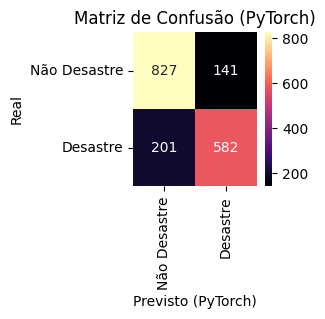

In [8]:
print("\nAvaliando o modelo no conjunto de teste...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        preds = (outputs > 0.4462).float()  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

unique_preds, counts_preds = np.unique(all_preds, return_counts=True)
print(f"Distribuição das previsões finais: {dict(zip(unique_preds, counts_preds))}")

# Calculando métricas

accuracy = accuracy_score(all_labels, all_preds)
f1_pytorch = f1_score(all_labels, all_preds)

print(f'Acurácia com PyTorch: {accuracy:.4f}')
print(f'F1-score com PyTorch: {f1_pytorch:.4f}')

print('\nRelatório de Classificação (PyTorch):')
print(classification_report(all_labels, all_preds))

# Matrix de confusão

cm_pytorch = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(2,2))
sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='magma',
            xticklabels=['Não Desastre', 'Desastre'],
            yticklabels=['Não Desastre', 'Desastre'])

plt.xlabel('Previsto (PyTorch)')
plt.ylabel('Real')
plt.title('Matriz de Confusão (PyTorch)')
plt.show()

**TREINO + AVALIAÇÃO DO MODELO**

In [9]:
# Verificar os dados
print(f"Tamanho do conjunto de teste do Kaggle: {test.shape}")
print(f"Colunas no conjunto de teste: {test.columns.tolist()}")
print(f"Formato do arquivo de submissão: {sample_submission.columns.tolist()}")

# Preparar os dados de teste para predição
test_texts = test['text']  # Assumindo que a coluna de texto também se chama 'text' no arquivo de teste

# Gerar embeddings para os dados de teste
test_kaggle_embeddings = embedding_model.encode(test_texts, convert_to_tensor=True)

# Fazer predições no conjunto de teste do Kaggle
model.eval()
predictions = []

# Processar em batches para evitar problemas de memória
batch_size = 16
for i in range(0, len(test_kaggle_embeddings), batch_size):
    batch = test_kaggle_embeddings[i:i+batch_size].to(device)
    with torch.no_grad():
        outputs = model(batch)
        batch_preds = (outputs > 0.4462).float().cpu().numpy()  # Usando o mesmo threshold
        predictions.extend(batch_preds)

# Converter predições para o formato necessário
predictions = [int(pred[0]) for pred in predictions]

# Criar DataFrame de submissão
submission = pd.DataFrame({
    'id': test['id'],  # Assumindo que existe uma coluna 'id' no arquivo de teste
    'target': predictions
})

# Verificar se o formato corresponde ao sample_submission
print(f"Número de predições: {len(predictions)}")
print(f"Distribuição das predições: {pd.Series(predictions).value_counts().to_dict()}")
print(f"Primeiras 5 linhas da submissão:\n{submission.head(21)}")

# Salvar arquivo de submissão
submission.to_csv('submission.csv', index=False)
print("Arquivo de submissão 'submission.csv' criado com sucesso!")

Tamanho do conjunto de teste do Kaggle: (3263, 4)
Colunas no conjunto de teste: ['id', 'keyword', 'location', 'text']
Formato do arquivo de submissão: ['id', 'target']


Batches:   0%|          | 0/102 [00:00<?, ?it/s]

Número de predições: 3263
Distribuição das predições: {0: 1994, 1: 1269}
Primeiras 5 linhas da submissão:
    id  target
0    0       0
1    2       1
2    3       1
3    9       1
4   11       1
5   12       0
6   21       0
7   22       0
8   27       0
9   29       0
10  30       0
11  35       0
12  42       0
13  43       0
14  45       0
15  46       1
16  47       0
17  51       1
18  58       0
19  60       0
20  69       1
Arquivo de submissão 'submission.csv' criado com sucesso!


In [10]:
submission.shape

(3263, 2)

**LOGISTIC REGRESSION**

In [11]:
"""
# 7. Treinamento do modelo de Regressão Logística (aplicando o melhor parâmetro C encontrado anteriormente)
logistic_model = LogisticRegression(solver='liblinear', random_state=19, C=10)
logistic_model.fit(x_train_tfidf, y_train)

# 8. Predições
y_pred_logistic = logistic_model.predict(x_test_tfidf)

# 9. Avaliação
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Acurácia do modelo de Regressão Logística: {accuracy_logistic:.4f}')
print('\nRelatório de Classificação (Regressão Logística):')
print(classification_report(y_test, y_pred_logistic))

cm_logistic = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(2,2))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues',
            xticklabels=logistic_model.classes_, yticklabels=logistic_model.classes_)
plt.xlabel('Previsto (Regressão Logística)')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Regressão Logística)')
plt.show()

f1_logistic = f1_score(y_test, y_pred_logistic)
print(f'F1-score da Regressão Logística: {f1_logistic:.4f}')"""

"\n# 7. Treinamento do modelo de Regressão Logística (aplicando o melhor parâmetro C encontrado anteriormente)\nlogistic_model = LogisticRegression(solver='liblinear', random_state=19, C=10)\nlogistic_model.fit(x_train_tfidf, y_train)\n\n# 8. Predições\ny_pred_logistic = logistic_model.predict(x_test_tfidf)\n\n# 9. Avaliação\naccuracy_logistic = accuracy_score(y_test, y_pred_logistic)\nprint(f'Acurácia do modelo de Regressão Logística: {accuracy_logistic:.4f}')\nprint('\nRelatório de Classificação (Regressão Logística):')\nprint(classification_report(y_test, y_pred_logistic))\n\ncm_logistic = confusion_matrix(y_test, y_pred_logistic)\nplt.figure(figsize=(2,2))\nsns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues',\n            xticklabels=logistic_model.classes_, yticklabels=logistic_model.classes_)\nplt.xlabel('Previsto (Regressão Logística)')\nplt.ylabel('Real')\nplt.title('Matriz de Confusão (Regressão Logística)')\nplt.show()\n\nf1_logistic = f1_score(y_test, y_pred_logistic)

In [12]:
"""from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define os valores de C que você quer testar
param_grid_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Cria o modelo de Regressão Logística
logistic_model = LogisticRegression(solver='liblinear', random_state=19)

# Configura o GridSearchCV
grid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=5, scoring='f1')

# Executa a busca nos dados de treinamento
grid_search_logistic.fit(x_train_tfidf, y_train)

# Melhores parâmetros encontrados
print("Melhores hiperparâmetros para Regressão Logística:", grid_search_logistic.best_params_)

# Melhor score (F1) obtido
print("Melhor F1-score para Regressão Logística:", grid_search_logistic.best_score_)

# Avalia o modelo com os melhores parâmetros no conjunto de teste
best_logistic_model = grid_search_logistic.best_estimator_
y_pred_best_logistic = best_logistic_model.predict(x_test_tfidf)

f1_best_logistic = f1_score(y_test, y_pred_best_logistic)
accuracy_best_logistic = accuracy_score(y_test, y_pred_best_logistic)

print(f'Acurácia da Regressão Logística (melhores parâmetros): {accuracy_best_logistic:.4f}')
print(f'F1-score da Regressão Logística (melhores parâmetros): {f1_best_logistic:.4f}')

print("\nRelatório de Classificação da Regressão Logística (melhores parâmetros):")
print(classification_report(y_test, y_pred_best_logistic))

cm_best_logistic = confusion_matrix(y_test, y_pred_best_logistic)
plt.figure(figsize=(2,2))
sns.heatmap(cm_best_logistic, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_logistic_model.classes_, yticklabels=best_logistic_model.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Regressão Logística - Melhores Parâmetros)')
plt.show()"""

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\n\n# Define os valores de C que você quer testar\nparam_grid_logistic = {\'C\': [0.001, 0.01, 0.1, 1, 10, 100]}\n\n# Cria o modelo de Regressão Logística\nlogistic_model = LogisticRegression(solver=\'liblinear\', random_state=19)\n\n# Configura o GridSearchCV\ngrid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=5, scoring=\'f1\')\n\n# Executa a busca nos dados de treinamento\ngrid_search_logistic.fit(x_train_tfidf, y_train)\n\n# Melhores parâmetros encontrados\nprint("Melhores hiperparâmetros para Regressão Logística:", grid_search_logistic.best_params_)\n\n# Melhor score (F1) obtido\nprint("Melhor F1-score para Regressão Logística:", grid_search_logistic.best_score_)\n\n# Avalia o modelo com os melhores parâmetros no conjunto de teste\nbest_logistic_model = grid_search_logistic.best_estimator_\ny_pred_best_logistic = best_logistic_model.predict(x_test_tfidf)\n

XGBoost

In [13]:
"""
# 7. Treinamento do modelo XGBoost
xgb_model = XGBClassifier(random_state=19)
xgb_model.fit(x_train_tfidf, y_train)

# 8. Predições
y_pred_xgb = xgb_model.predict(x_test_tfidf)

# 9. Avaliação
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Acurácia do modelo XGBoost: {accuracy_xgb:.4f}')
print('\nRelatório de Classificação (XGBoost):')
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(2,2))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='plasma',
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Previsto (XGBoost)')
plt.ylabel('Real')
plt.title('Matriz de Confusão (XGBoost)')
plt.show()

f1_xgb = f1_score(y_test, y_pred_xgb)
print(f'F1-score do XGBoost: {f1_xgb:.4f}')"""

"\n# 7. Treinamento do modelo XGBoost\nxgb_model = XGBClassifier(random_state=19)\nxgb_model.fit(x_train_tfidf, y_train)\n\n# 8. Predições\ny_pred_xgb = xgb_model.predict(x_test_tfidf)\n\n# 9. Avaliação\naccuracy_xgb = accuracy_score(y_test, y_pred_xgb)\nprint(f'Acurácia do modelo XGBoost: {accuracy_xgb:.4f}')\nprint('\nRelatório de Classificação (XGBoost):')\nprint(classification_report(y_test, y_pred_xgb))\n\ncm_xgb = confusion_matrix(y_test, y_pred_xgb)\nplt.figure(figsize=(2,2))\nsns.heatmap(cm_xgb, annot=True, fmt='d', cmap='plasma',\n            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)\nplt.xlabel('Previsto (XGBoost)')\nplt.ylabel('Real')\nplt.title('Matriz de Confusão (XGBoost)')\nplt.show()\n\nf1_xgb = f1_score(y_test, y_pred_xgb)\nprint(f'F1-score do XGBoost: {f1_xgb:.4f}')"

SVM

In [14]:
"""from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC

# Define os valores de C e os kernels que você quer testar
param_grid_svm = {'C': [0.1, 1, 10, 100],
                  'kernel': ['linear', 'rbf']}

# Cria o modelo SVM
svm_model = SVC(random_state=19)

# Configura o GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='f1')

# Executa a busca nos dados de treinamento
grid_search_svm.fit(x_train_tfidf, y_train)

# Melhores parâmetros encontrados
print("Melhores hiperparâmetros para SVM:", grid_search_svm.best_params_)

# Melhor score (F1) obtido
print("Melhor F1-score para SVM:", grid_search_svm.best_score_)

# Avalia o modelo com os melhores parâmetros no conjunto de teste
best_svm_model = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm_model.predict(x_test_tfidf)

f1_best_svm = f1_score(y_test, y_pred_best_svm)
accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)

print(f'Acurácia do SVM (melhores parâmetros): {accuracy_best_svm:.4f}')
print(f'F1-score do SVM (melhores parâmetros): {f1_best_svm:.4f}')

print("\nRelatório de Classificação do SVM (melhores parâmetros):")
print(classification_report(y_test, y_pred_best_svm))

cm_best_svm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(2,2))
sns.heatmap(cm_best_svm, annot=True, fmt='d', cmap='viridis',
            xticklabels=best_svm_model.classes_, yticklabels=best_svm_model.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão (SVM - Melhores Parâmetros)')
plt.show()"""

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score\nfrom sklearn.svm import SVC\n\n# Define os valores de C e os kernels que você quer testar\nparam_grid_svm = {\'C\': [0.1, 1, 10, 100],\n                  \'kernel\': [\'linear\', \'rbf\']}\n\n# Cria o modelo SVM\nsvm_model = SVC(random_state=19)\n\n# Configura o GridSearchCV\ngrid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring=\'f1\')\n\n# Executa a busca nos dados de treinamento\ngrid_search_svm.fit(x_train_tfidf, y_train)\n\n# Melhores parâmetros encontrados\nprint("Melhores hiperparâmetros para SVM:", grid_search_svm.best_params_)\n\n# Melhor score (F1) obtido\nprint("Melhor F1-score para SVM:", grid_search_svm.best_score_)\n\n# Avalia o modelo com os melhores parâmetros no conjunto de teste\nbest_svm_model = grid_search_svm.best_estimator_\ny_pred_best_svm = best_svm_model.predict(x_test_tfidf)\n\nf1_best_svm = f1_scor

In [15]:
"""# 2. Remoção de stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords
stop_words = set(stop_words)


def clean_text(mensage):
    mensage = str(mensage).lower()
    mensage = re.sub('\[.*?\]', '', mensage)
    mensage = re.sub('https?://\S+|www\.\S+', '', mensage)
    mensage = re.sub('<.*?>+', '', mensage)
    mensage = re.sub('[%s]' % re.escape(string.punctuation), '', mensage)
    mensage = re.sub('\n', '', mensage)
    mensage = re.sub('\w*\d\w*', '', mensage)
    return mensage

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)



def remove_stopwords(mensage):
    mensage = ' '.join(word for word in mensage.split(' ') if word not in stop_words)
    return mensage

train_df['text'] = train_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)

# Divisão dos dados
x = train_df['text']
y = train_df['target']

# Removendo o documento vazio (índice 217)
empty_index = 217
if empty_index in x.index:
    x = x.drop(index=empty_index)
    y = y.drop(index=empty_index)
    # Precisa resetar o index
    x = x.reset_index(drop=True)  
    y = y.reset_index(drop=True) 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.21, random_state=19)

# Carregar o modelo Sentence Transformer
model_name = 'all-mpnet-base-v2'
embedding_model = SentenceTransformer(model_name)

# Gerar os embeddings
# Converter x_train e x_test para lista antes de  encode
x_train_embeddings = embedding_model.encode(x_train.tolist(), convert_to_tensor=True)  
x_test_embeddings = embedding_model.encode(x_test.tolist(), convert_to_tensor=True)  

# Move the tensors to CPU and convert to NumPy arrays
x_train_embeddings = x_train_embeddings.cpu().numpy()  
x_test_embeddings = x_test_embeddings.cpu().numpy()

# Treinar o modelo de Regressão Logística
from sklearn.linear_model import LogisticRegression # Importing the missing module
logistic_model = LogisticRegression(random_state=19, solver='liblinear')
logistic_model.fit(x_train_embeddings, y_train)

# Fazer as previsões
y_pred_sentence_transformer = logistic_model.predict(x_test_embeddings)

# Avaliar o modelo
accuracy_sentence_transformer = accuracy_score(y_test, y_pred_sentence_transformer)
f1_sentence_transformer = f1_score(y_test, y_pred_sentence_transformer)

print(f'Acurácia com Sentence Transformer: {accuracy_sentence_transformer:.4f}')
print(f'F1-score com Sentence Transformer: {f1_sentence_transformer:.4f}')

print('\nRelatório de Classificação (Sentence Transformer):')
print(classification_report(y_test, y_pred_sentence_transformer))

cm_sentence_transformer = confusion_matrix(y_test, y_pred_sentence_transformer)
plt.figure(figsize=(2,2))
sns.heatmap(cm_sentence_transformer, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Não Desastre', 'Desastre'], yticklabels=['Não Desastre', 'Desastre'])
plt.xlabel('Previsto (Sentence Transformer)')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Sentence Transformer)')
plt.show()"""

"# 2. Remoção de stopwords\nnltk.download('stopwords')\nstop_words = stopwords.words('english')\nmore_stopwords = ['u', 'im', 'c']\nstop_words = stop_words + more_stopwords\nstop_words = set(stop_words)\n\n\ndef clean_text(mensage):\n    mensage = str(mensage).lower()\n    mensage = re.sub('\\[.*?\\]', '', mensage)\n    mensage = re.sub('https?://\\S+|www\\.\\S+', '', mensage)\n    mensage = re.sub('<.*?>+', '', mensage)\n    mensage = re.sub('[%s]' % re.escape(string.punctuation), '', mensage)\n    mensage = re.sub('\n', '', mensage)\n    mensage = re.sub('\\w*\\d\\w*', '', mensage)\n    return mensage\n\ntrain_df['text'] = train_df['text'].apply(clean_text)\ntest_df['text'] = test_df['text'].apply(clean_text)\n\n\n\ndef remove_stopwords(mensage):\n    mensage = ' '.join(word for word in mensage.split(' ') if word not in stop_words)\n    return mensage\n\ntrain_df['text'] = train_df['text'].apply(remove_stopwords)\ntest_df['text'] = test_df['text'].apply(remove_stopwords)\n\n# Divisão